### conditional GAN

https://github.com/arturmml/mnist-cgan/blob/master/mnist-cgan.ipynb

In [1]:
import pandas as pd
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import os
import tensorflow as tf
from time import time
import pickle
import datetime
import random
import math
import csv
import time
import sys

In [2]:
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset  
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [4]:
from src.models.model import AE_base
from src.data.common.dataset import FontDataset, PickledImageProvider

In [5]:
import torch
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
batch_size = 8
validation_split = .15
test_split = .05
shuffle_dataset = True
random_seed = 42

lr = 0.0001

log_interval = 10
epochs = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
from src.data.common.dataset import NewFontDataset, PickledImageProvider

In [8]:
# get Dataset
data_dir = 'src/data/dataset/allfonts/'
train_set = NewFontDataset(PickledImageProvider(data_dir+'train.obj'))
valid_set = NewFontDataset(PickledImageProvider(data_dir+'val.obj'))
test_set = NewFontDataset(PickledImageProvider(data_dir+'test.obj'))

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [9]:
# get idx samplers
train_set_size = len(train_set)
valid_set_size = len(valid_set)
train_idxs = list(range(train_set_size))
valid_idxs = list(range(valid_set_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_idxs)
    np.random.shuffle(valid_idxs)

train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(valid_idxs)

# get data_loaders
train_loader = DataLoader(train_set, 
                      batch_size=batch_size,
                      sampler=train_sampler
                      )
valid_loader = DataLoader(valid_set,
                        batch_size=batch_size,
                        sampler=valid_sampler
                        )
test_loader = DataLoader(test_set,
                        batch_size=len(test_set)
                        )

---

In [26]:
input_category_size=5; input_alpha_size=52; input_font_size=128*128

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()     
        input_size = input_font_size + input_alpha_size + input_category_size

        self.model = nn.Sequential(
            nn.Linear(input_size, 8192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(8192, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )        
    
    def forward(self, x_font, alpha_vector, category_vector):
        x_font = x_font.view(x_font.shape[0], -1)
        alpha_vector = alpha_vector.view(alpha_vector.shape[0], -1)
        category_vector = category_vector.view(category_vector.shape[0], -1)

        x = torch.cat([x_font, category_vector, alpha_vector], dim=1)
        out = self.model(x)
        
        return out.squeeze()

In [27]:
input_category_size=5; input_alpha_size=52; input_font_size=128*128; input_noise_size = 16;
output_font_size=128*128

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = input_noise_size + input_alpha_size + input_category_size
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(4096, 8192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8192, output_font_size)
        )        
    
    def forward(self, noise, alpha_vector, category_vector):
        noise = noise.view(noise.shape[0], -1)
        alpha_vector = alpha_vector.view(alpha_vector.shape[0], -1)
        category_vector = category_vector.view(category_vector.shape[0], -1)        
        
        x = torch.cat([noise, category_vector, alpha_vector], dim=1)        
        out = self.model(x)
        
        return out.view(x.size(0), 128, 128)

In [12]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()

In [13]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [59]:
def train_discriminator(batch_size, generator, discriminator, images, alpha_vector, category_vector):
    d_optimizer.zero_grad()
    
    #train with the real image
    outputs = discriminator(images, alpha_vector, category_vector)
    real_loss = criterion(outputs, Variable(torch.ones(batch_size)).cuda()) 
    real_score = outputs 
    
    # Sample for generator
    noise = Variable(torch.randn(batch_size, 16).cuda()) 
    fake_alpha_vector =  Variable(torch.FloatTensor(np.eye(52)[np.random.choice(52,batch_size)])).cuda()
    fake_category_vector =  Variable(torch.FloatTensor(np.eye(5)[np.random.choice(5,batch_size)])).cuda()
    
    #train with the fake image
    fake_images = generator(noise, fake_alpha_vector, fake_category_vector) 
    outputs = discriminator(fake_images, fake_alpha_vector, fake_category_vector)    
    fake_loss = criterion(outputs, Variable(torch.zeros(batch_size)).cuda()) 
    fake_score = outputs 

    d_loss = real_loss + fake_loss 
    d_loss.backward() 
    d_optimizer.step()
    
    return d_loss, real_score, fake_score



In [60]:
def train_generator(batch_size, generator, discriminator):

    g_optimizer.zero_grad()
    
    # Sample again for the generator and get output from discriminator
    noise = Variable(torch.randn(batch_size, 16).cuda())
    fake_alpha_vector = Variable(torch.FloatTensor(np.eye(52)[np.random.choice(52,batch_size)])).cuda()
    fake_category_vector = Variable(torch.FloatTensor(np.eye(5)[np.random.choice(5,batch_size)])).cuda()
   
    fake_images = generator(noise, fake_alpha_vector, fake_category_vector) 
    outputs = discriminator(fake_images, fake_alpha_vector, fake_category_vector)

    g_loss = criterion(outputs, Variable(torch.ones(batch_size)).cuda()) 
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [156]:
# set number of epochs and initialize figure counter
num_epochs = 100
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (vectors, font, _) in enumerate(train_loader):
        
        
        alpha_vector = vectors['alphabet_vector']
        category_vector = vectors['category_vector']
        
        images, alpha_vector = font.float().to(device), alpha_vector.float().to(device)
        category_vector = category_vector.float().to(device)
 
            
    
        # Train the discriminator
        d_loss, real_score, fake_score =train_discriminator(batch_size, generator, discriminator, images, alpha_vector, category_vector)
                
        # Train the generator
        g_loss = train_generator(batch_size, generator, discriminator)
     
        if n % 1000 == 0: print(n, " / ")
            
        
    if epoch % 1 == 0:
        print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f' 
              %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                real_score.data.mean(), fake_score.data.mean()))


0  / 
1000  / 
2000  / 
3000  / 


C:\Users\nancy\Anaconda3\envs\subin2\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


ValueError: Target and input must have the same number of elements. target nelement (8) != input nelement (1)

In [83]:
len(train_loader)

3147

In [157]:
n

3146

In [82]:
n

2392

In [158]:
alpha_vector.size()

torch.Size([1, 52])

In [159]:
vectors

{'category_vector': tensor([[0, 0, 1, 0, 0]]),
 'font': tensor([178]),
 'alphabet_vector': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]])}

In [178]:
nn=3145
for nn, (vectors1, font, _) in enumerate(train_loader):
    
    alpha_vector1 = vectors1['alphabet_vector']
    category_vector1 = vectors1['category_vector']
    if nn ==3146 : break

In [179]:
nn

3146

In [180]:
vectors1

{'category_vector': tensor([[0, 0, 0, 1, 0]]),
 'font': tensor([47]),
 'alphabet_vector': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]])}

## 왜 ??? 3146에서 batch가 하나야? -> 여기서 에러떠서 학습 못함

---

In [184]:
# set number of epochs and initialize figure counter
num_epochs = 100
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (vectors, font, _) in enumerate(train_loader):
        
        
        alpha_vector = vectors['alphabet_vector']
        category_vector = vectors['category_vector']
        
        images, alpha_vector = font.float().to(device), alpha_vector.float().to(device)
        category_vector = category_vector.float().to(device)
 
        if alpha_vector.size()[0] != batch_size : continue    
    
        # Train the discriminator
        d_loss, real_score, fake_score =train_discriminator(batch_size, generator, discriminator, images, alpha_vector, category_vector)
        
        
        # Train the generator
        g_loss = train_generator(batch_size, generator, discriminator)
     
        if n % 1000 == 0: print(n, " / ")
            
        
    if epoch % 1 == 0:
        print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f' 
              %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                real_score.data.mean(), fake_score.data.mean()))


0  / 
1000  / 
2000  / 
3000  / 
Epoch [1/100], Step[3147/3147], d_loss: 0.8176, g_loss: 0.9287, D(x): 0.83, D(G(z)): 0.43
0  / 
1000  / 
2000  / 
3000  / 
Epoch [2/100], Step[3147/3147], d_loss: 1.3864, g_loss: 0.9718, D(x): 0.39, D(G(z)): 0.35
0  / 
1000  / 
2000  / 
3000  / 
Epoch [3/100], Step[3147/3147], d_loss: 1.2709, g_loss: 0.7181, D(x): 0.81, D(G(z)): 0.62
0  / 
1000  / 
2000  / 
3000  / 
Epoch [4/100], Step[3147/3147], d_loss: 1.7960, g_loss: 0.5267, D(x): 0.55, D(G(z)): 0.61
0  / 
1000  / 
2000  / 
3000  / 
Epoch [5/100], Step[3147/3147], d_loss: 1.3144, g_loss: 0.7449, D(x): 0.52, D(G(z)): 0.48
0  / 
1000  / 
2000  / 
3000  / 
Epoch [6/100], Step[3147/3147], d_loss: 1.4592, g_loss: 0.9304, D(x): 0.41, D(G(z)): 0.43
0  / 
1000  / 
2000  / 
3000  / 
Epoch [7/100], Step[3147/3147], d_loss: 1.4291, g_loss: 1.2387, D(x): 0.38, D(G(z)): 0.37
0  / 
1000  / 
2000  / 
3000  / 
Epoch [8/100], Step[3147/3147], d_loss: 1.4004, g_loss: 0.9616, D(x): 0.42, D(G(z)): 0.40
0  / 
1000  / 
2

In [229]:
# save
savePath = "D:/투빅스 2019/generator_1210.pth"
torch.save(generator.state_dict(), savePath)



In [230]:
# save
savePath = "D:/투빅스 2019/discriminator_1210.pth"
torch.save(discriminator.state_dict(), savePath)



In [ ]:
# load
#new_model = TestModel()
#new_model.load_state_dict(torch.load("./output/test_model.pth"))


In [ ]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()

---

In [211]:
z = Variable(torch.randn(52, 16)).cuda()
fake_alpha_vector =  Variable(torch.FloatTensor(np.eye(52))).cuda()
fake_category_vector =  Variable(torch.FloatTensor(np.eye(5)[np.random.choice(5,52)])).cuda()


In [212]:
images = generator(z, fake_alpha_vector, fake_category_vector).unsqueeze(1)

In [213]:
grid = make_grid(images, nrow=52, normalize=True)

In [214]:
images = images.view(images.size(0), 128, 128)

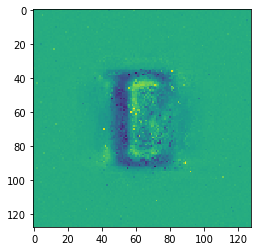

In [215]:
plt.imshow(images[3].cpu().detach().numpy())

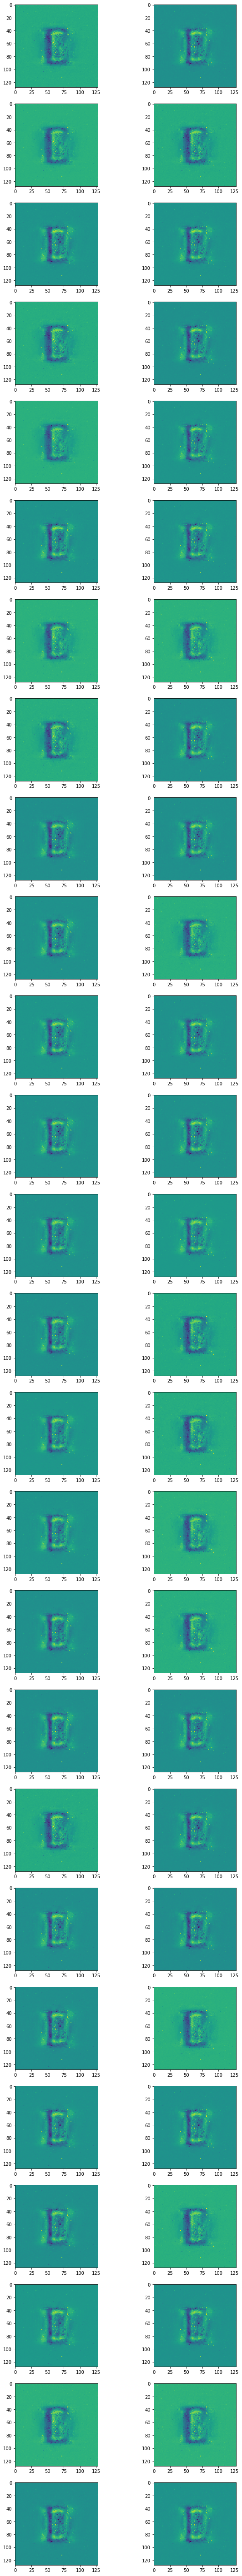

In [216]:
plt.figure(figsize=(10, 200))
for i in range(52):
    plt.subplot(50, 2, i+1)
    plt.imshow(images[i].cpu().detach().numpy())